<a href="https://colab.research.google.com/github/Olena-geo/Semi_supervised_learning_labs/blob/main/ssl_lab01_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Виконання роботи
1. Виконати налаштування робочого середовища.
(Наче налаштувала).

2. Встановити сід генератора псевдовипадкових чисел:
torch.manual_seed(0), де 0 - число, з якого починається генерація (для забезпечення повторюваності результатів)

In [32]:
import torch
torch.manual_seed(0)

3. Завантажити обраний набір даних.
Для варіанта 2 - FashionMNIST

Завантажуємо за допомогою абстракції Dataset


In [33]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

fashion_mnist_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)


'\ntraining_data = datasets.FashionMNIST(\n    root="data",\n    train=True,\n    download=True,\n    transform=ToTensor()\n)\n\ntest_data = datasets.FashionMNIST(\n    root="data",\n    train=False,\n    download=True,\n    transform=ToTensor()\n)\n'

4. [*] Відобразити декілька зображень з набору даних у блокноті

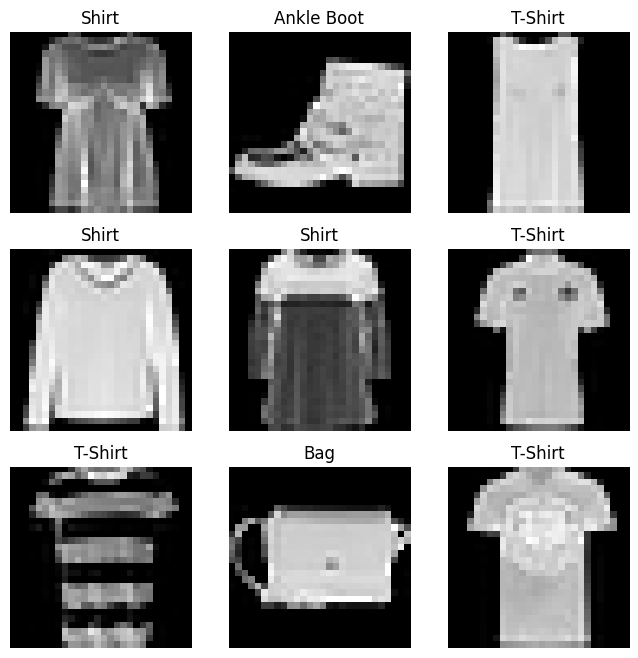

In [34]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

5. Розділити обраний набір даних на три вибірки: тренувальну, валідаційну та тестову. Співвідношення розміру вибірок обрати на власний розсуд


In [35]:
from torch.utils.data import DataLoader, random_split

# Розділити набір даних на тренувальну, валідаційну і тестову вибірки
# Зазвичай рекомендується використовувати співвідношення близько 70% тренувальної, 15% валідаційної і 15% тестової вибірок
train_size = int(0.7 * len(fashion_mnist_dataset))
val_size = int(0.15 * len(fashion_mnist_dataset))
test_size = len(fashion_mnist_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(fashion_mnist_dataset, [train_size, val_size, test_size])

# Завантажити дані у DataLoader для зручності навчання
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


6. Завантажити та налаштувати нейронну мережу обраної архітектури.
Для варіанта 2 - AlexNet

In [36]:
import torch.nn as nn
import torchvision.models as models

alexnet = models.alexnet(pretrained=True)

# Заміна першого згорткового шару для відповідності кількості каналів у вхідних даних (1 канал для FashionMNIST, тоді як стандартно - 3)
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# Заміна останнього повнозв'язного шару для відповідності кількості класів FashionMNIST (10 класів)
num_classes = 10
alexnet.classifier[6] = nn.Linear(4096, num_classes)

# Переконатися, що будуть навчатися всі параметри мережі
for param in alexnet.parameters():
    param.requires_grad = True

# Перевірка структури мережі
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

Вибір гіперпараметрів:

Функція втрати:
наприклад, CrossEntropyLoss для класифікації.
Оптимізатор: наприклад, Adam.
Кількість епох: наприклад 10


In [37]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)
num_epochs = 10


Навчання нейронної мережі:

In [38]:
import numpy as np

train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    # Тренування мережі
    alexnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    # Оцінка мережі на валідаційному наборі
    alexnet.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = alexnet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")


Epoch [1/10] - Train Loss: 0.6474, Train Acc: 76.09%, Val Loss: 0.4974, Val Acc: 81.73%
Epoch [2/10] - Train Loss: 0.4338, Train Acc: 84.66%, Val Loss: 0.3776, Val Acc: 86.38%
Epoch [3/10] - Train Loss: 0.3673, Train Acc: 86.77%, Val Loss: 0.3443, Val Acc: 87.86%
Epoch [4/10] - Train Loss: 0.3317, Train Acc: 88.07%, Val Loss: 0.3125, Val Acc: 88.29%
Epoch [5/10] - Train Loss: 0.2958, Train Acc: 89.29%, Val Loss: 0.2876, Val Acc: 89.47%
Epoch [6/10] - Train Loss: 0.2779, Train Acc: 90.07%, Val Loss: 0.2793, Val Acc: 90.03%
Epoch [7/10] - Train Loss: 0.2530, Train Acc: 91.02%, Val Loss: 0.2722, Val Acc: 90.52%
Epoch [8/10] - Train Loss: 0.2475, Train Acc: 91.17%, Val Loss: 0.2918, Val Acc: 89.61%
Epoch [9/10] - Train Loss: 0.2275, Train Acc: 91.90%, Val Loss: 0.2728, Val Acc: 90.33%
Epoch [10/10] - Train Loss: 0.2179, Train Acc: 92.26%, Val Loss: 0.3037, Val Acc: 89.41%


In [40]:
# Зберегти ваги моделі
torch.save(alexnet.state_dict(), 'alexnet_fashionmnist_weights_1.pth')

In [43]:
from google.colab import files

# Вказати шлях до файла з вагами
file_path = 'alexnet_fashionmnist_weights_1.pth'

# Завантажити файл на локальний комп'ютер
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

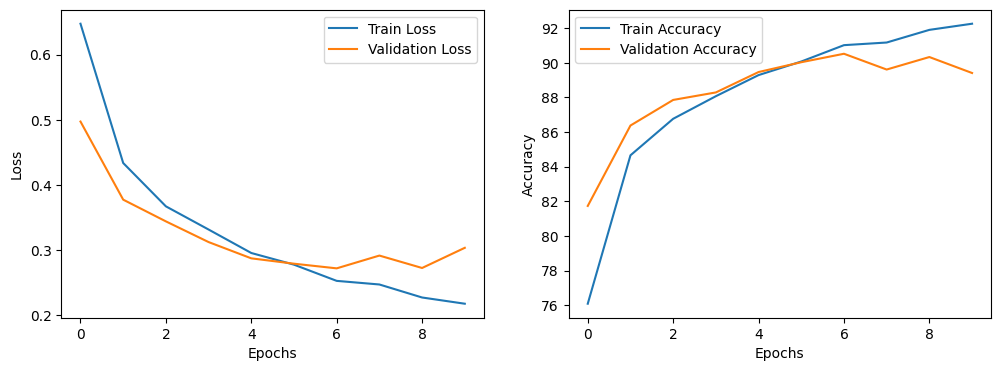

In [47]:
import matplotlib.pyplot as plt

# Побудувати графіки точності та втрати
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()